In [1]:
# import libraries
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as scs
from statsmodels.tsa.stattools import adfuller, kpss
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [3]:
# Define a function for running the ADF test

def adf_test(x):
    indices = ['Test Statistic', 'p-value', '# of Lags Used', '# of Observations Used']
    
    adf_test = adfuller(x, autolag = 'AIC')
    results = pd.Series(adf_test[:4], index = indices)
    
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value
    return results

In [4]:
def kpss_test(x, h0_type='c'):
    indices = ['Test Statistic', 'p-value', '# of Lags']
    kpss_test = kpss(x, regression = h0_type)
    
    results = pd.Series(kpss_test[:3], index = indices)
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value
    return results

In [5]:
def test_autocorrelation(x, n_lags=40, alpha=0.05, h0_type='c'):
    adf_results = adf_test(x)
    kpss_results = kpss_test(x, h0_type = h0_type)
    
    print('ADF test statisti {:.2f} (p-val: {:.2f})'.format(adf_results['Test Statistic'], 
                                                              adf_results['p-value']))
    print('KPSS test statistic {:.2f} (p-val: {:.2f})'.format(kpss_results['Test Statistic'],
                                                              adf_results['p-value']))
    fig, ax = plt.subplots(2, figsize = (14, 8))
    
    plot_acf(x, ax = ax[0], lags = n_lags, alpha = alpha)
    plot_pacf(x, ax = ax[1], lags = n_lags, alpha=alpha)
    
    
#     return fig

In [6]:
# download google stock prices and resample them to weekly frequencies

df = yf.download('GOOG', start = '2015-01-01',
                 adjusted = True)
goog = df.resample('W').last().rename(columns = {'Adj Close': 'adj_close'}).adj_close

[*********************100%***********************]  1 of 1 completed


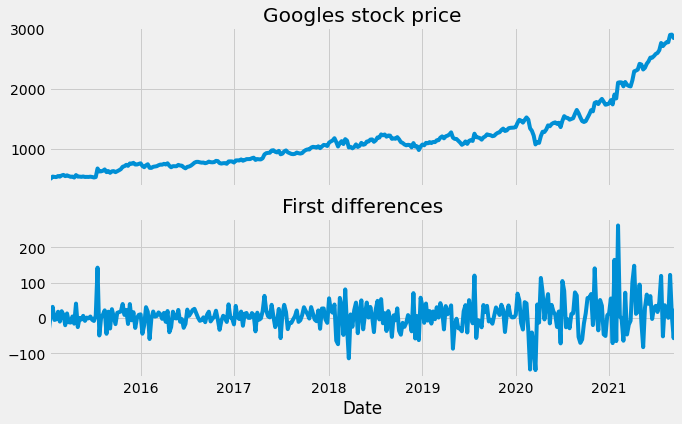

In [7]:
# Apply first differences and plot them together
plt.style.use('fivethirtyeight')
goog_diff = goog.diff().dropna()
fig, ax = plt.subplots(2, figsize = (10, 6), sharex = True)
goog.plot(title = 'Googles stock price', ax = ax[0])
goog_diff.plot(ax = ax[1], title = 'First differences')
plt.show()

/Users/anna/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


ADF test statisti -19.80 (p-val: 0.00)
KPSS test statistic 0.66 (p-val: 0.00)


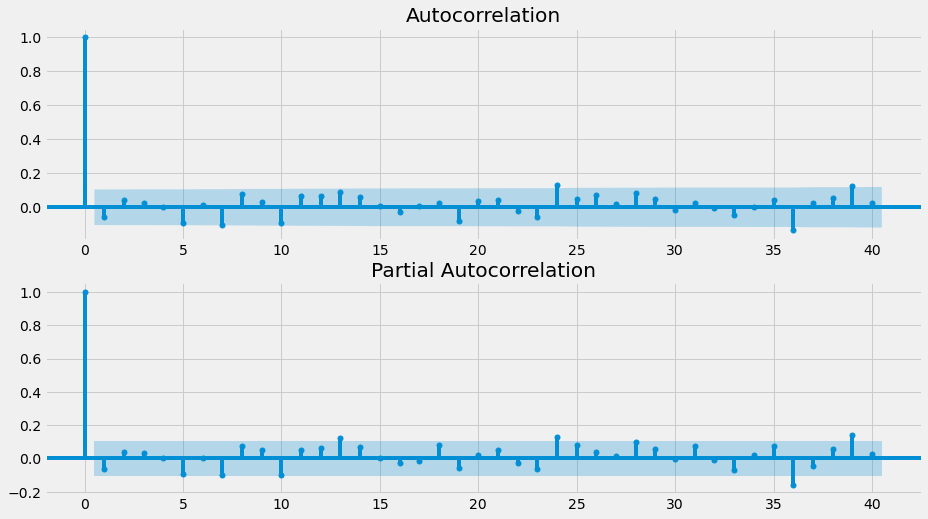

In [8]:
# test the series for autocorrelation
test_autocorrelation(goog_diff)

In [9]:
# The results indicate that the differenced prices are stationary

# specify the ARIMA model and fit it to the data

arima = ARIMA(goog, order = (2, 1, 1)).fit(disp = 0)
arima.summary()

/Users/anna/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/anna/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmod

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.adj_close   No. Observations:                  350
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1803.551
Method:                       css-mle   S.D. of innovations             41.848
Date:                Mon, 13 Sep 2021   AIC                           3617.102
Time:                        17:26:26   BIC                           3636.391
Sample:                    01-11-2015   HQIC                          3624.780
                         - 09-19-2021                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 6.6824      2.235      2.990      0.003       2.302      11.063
ar.L1.D.adj_close     0.1924      0.552      0.348      0.728      -0.890       1.274
ar.L2.D.adj_close     0.0578      0.060      0.967      0.333      -0.059       0.175
ma.L1.D.adj_close    -0.2506      0.551     -0.455      0.649      -1.330       0.829
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.8167           +0.0000j            2.8167            0.0000
AR.2           -6.1474           +0.0000j            6.1474            0.5000
MA.1            3.9909           +0.0000j            3.9909            0.0000
-----------------------------------------------------------------------------
"""

In [10]:
# prepare a function for diagnosing the fit of the model based on its residuals

def arima_diagnostics(resids, n_lags = 40):
    # create a placeholder subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (12, 8))
    r = resids
    
    resids = (r - np.nanmean(r)) / np.nanstd(r)
    resids_nonmissing = resids[~(np.isnan(resids))]
    
    # residuals over time
    sns.lineplot(x = np.arange(len(resids)), y = resids, ax =ax1)
    ax1.set_title('Standardized residuals')
    
    # distribution of residuals
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    sns.distplot(resids_nonmissing, hist = True, kde = True,  norm_hist = True, ax = ax2)
    ax2.plot(r_range, norm_pdf, 'g', lw = 2, label = 'N(0,1)')
    ax2.set_title('Ditribution of standardized residuals')
    ax2.set_xlim(x_lim)
    ax2.legend()
    
    # QQ-plot
    qq = sm.qqplot(resids_nonmissing, line = 's', ax = ax3)
    ax3.set_title('Q-Q plot')
    
    # ACF plot
    plot_acf(resids, ax = ax4, lags = n_lags, alpha = 0.05)
    ax4.set_title('ACF plot')
#     return fig
    
    

In [ ]:
# test the residuals of the fitted ARIMA model

arima_diagnostics(arima.resid, 40)

In [ ]:
# The average of residuals is close to 0, inspection of an acf plot leads to conclusion that it is a good fit.

In [ ]:
# Apply Ljung-Box test for no autocorrelations in the residuals
ljung_box_results = acorr_ljungbox(arima.resid)

fig, ax = plt.subplots(1, figsize = (12, 5))
sns.scatterplot(x = range(len(ljung_box_results[1])),
               y =ljung_box_results[1], ax = ax)
ax.axhline(0.05, ls = '--',  c = 'r')
ax.set(title = 'Ljung-Box tests result', 
      xlabel = 'Lag', ylabel = 'p-value')
plt.show()

The results of the Ljung-Box test prove the null hypothesis of no significant autocorrelation for
any of the selected lags. This
indicates a good fit of the model.


## AUTO-ARIMA

In [ ]:
import pmdarima as pm

In [ ]:
# run autoarima
model = pm.auto_arima(goog, error_action = 'ignore', suppress_warnings = True,
                     seasonal = False)
model.summary()

In [ ]:
# try to tune the search for optimal parameters
model = pm.auto_arima(goog, error_action = 'ignore', suppress_warnings = True, seasonal = False,
                     stepwise = False, approximation = False, n_jobs = -1)
model.summary()

## Forecasting using ARIMA class models

In [ ]:
# we will forecast 3 first months of 2021


In [ ]:
# download additional data
df = yf.download('GOOG', start = '2021-01-01',
                end = '2021-03-31',
                adjusted = True)

test = df.resample('W').last().rename(columns = {'Adj Close': 'adj_close'}).adj_close

In [ ]:
# Obtain the forecasts from the first model and store them in a DataFrame
n_forecasts = len(test)
arima_pred = arima.forecast(n_forecasts)
print(arima_pred)
arima_pred = [pd.DataFrame(arima_pred[0], columns = ['prediction']), pd.DataFrame(arima_pred[2],
                                                    columns = ['ci_lower', 'ci_upper'] )]

arima_pred = pd.concat(arima_pred, axis = 1).set_index(test.index)

In [ ]:
arima_pred

In [ ]:
# obtain forecasts from the second model
auto_arima_pred = model.predict(n_periods= n_forecasts, return_conf_int=True, alpha = 0.05)

In [ ]:
auto_arima_pred = [pd.DataFrame(auto_arima_pred[0], columns = ['prediction']), pd.DataFrame(auto_arima_pred[1],
                                                                    columns = ['ci_lower', 'ci_upper'])]
auto_arima_pred = pd.concat(auto_arima_pred, axis = 1).set_index(test.index)

In [ ]:
# plot the results



In [ ]:
COLORS = ['blue', 'red', 'green']
fig, ax = plt.subplots(1, figsize = (12, 8))
ax = sns.lineplot(data=test, color=COLORS[0], label='Actual')

ax.plot(arima_pred.prediction, c=COLORS[1], label='ARIMA(2,1,1)')
ax.fill_between(arima_pred.index, arima_pred.ci_lower, arima_pred.ci_upper, alpha=0.3, facecolor=COLORS[1])

ax.plot(auto_arima_pred.prediction, c=COLORS[2], label='ARIMA(3,1,2)')
ax.fill_between(auto_arima_pred.index, auto_arima_pred.ci_lower, auto_arima_pred.ci_upper, 
                alpha=0.2, facecolor=COLORS[2])

ax.set(title="Google's stock price - actual vs. predicted",xlabel='Date', ylabel='Price ($)')
ax.legend(loc='upper left')
plt.show()